## 1. 데이터 개요

https://www.kaggle.com/c/santander-customer-satisfaction/   
- 370 개의 피처 데이터 셋을 이용해 고객 만족 여부를 예측하는 것이 목표
- 피처 이름은 모두 익명처리되어 있으며, TARGET 값이 1일 경우 불만, 0일 경우 만족
- 모델 성능 평가 : ROC - AUC

## 2. 데이터 전처리

In [3]:
# 라이브러리, 패키지, 데이터 임포트 및 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('/content/drive/MyDrive/ML/train_santander.csv')
print('dataset shape: ', cust_df.shape)
cust_df.head()

dataset shape:  (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
# 피처 타입, Null 값 확인
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


float형 데이터 111개, int형 데이터 260개, Null값 존재 X

In [5]:
# 만족/불만족 비율 확인
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('불만족 비율: {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
불만족 비율: 0.04


In [6]:
# 기초 통계량 확인
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

var3의 경우 최소값이 -999999 → 이상치 혹은 결측치 대체값일 가능성이 있음

In [7]:
cust_df.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

-999999의 경우 편차가 심한 값이므로 최빈값인 2로 대체

In [8]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)

# 피처셋, 레이블셋 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape: {0}'.format(X_features.shape))

피처 데이터 shape: (76020, 369)


In [9]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()

print(' 학습 데이터셋 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 데이터셋 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

 학습 데이터셋 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 데이터셋 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


학습 데이터셋과 테스트 데이터셋 모두 전체 데이터셋과 마찬가지로 약 4% 정도의 불만족 값으로 분할됨

## 3. 모델링 (XGBoost)

- n_estimators = 500
- early_stopping_rounds = 100
- 성능 평가 기준: ROC-AUC → eval_metric = 'auc'
- 평가 데이터 셋 → 테스트 데이터 셋 이용(과적합이 발생할 수 있으나 임의로 사용)   
→ eval_set = [(X_train, y_train), (X_test, y_test)]

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators = 500, random_state = 156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

칼럼의 개수가 많은편 → 과적합이 발생할 가능성을 가정   
→ max_depth, min_child_weight, colsample_bytree와 같은 하이퍼 파라미터 튜닝   
※ 학습 시간이 오래 걸리는 경우, 먼저 2 ~ 3개의 파라미터를 결합해서 튜닝, 그리고 다른 나머지 파라미터를 결합해서 튜닝을 할 경우 수월함

In [11]:
from sklearn.model_selection import GridSearchCV

# 속도를 위해 n_estimators 감소
xgb_clf = XGBClassifier(n_estimators = 100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# cv = 3
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터: ', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

ROC-AUC 점수가 0.8419에서 0.8461로 소폭 상승함

In [16]:
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02, max_depth = 5, min_child_weight = 1, colsample_bytree = 0.5, reg_alpha = 0.03)
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.817665	validation_1-auc:0.814986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.81987	validation_1-auc:0.814699
[2]	validation_0-auc:0.818798	validation_1-auc:0.813863
[3]	validation_0-auc:0.821696	validation_1-auc:0.815841
[4]	validation_0-auc:0.827716	validation_1-auc:0.822558
[5]	validation_0-auc:0.822253	validation_1-auc:0.818887
[6]	validation_0-auc:0.825218	validation_1-auc:0.818733
[7]	validation_0-auc:0.826898	validation_1-auc:0.820357
[8]	validation_0-auc:0.832836	validation_1-auc:0.827253
[9]	validation_0-auc:0.833574	validation_1-auc:0.827534
[10]	validation_0-auc:0.832205	validation_1-auc:0.825896
[11]	validation_0-auc:0.829664	validation_1-auc:0.824912
[12]	validation_0-auc:0.828593	validation_1-auc:0.824409
[13]	validation_0-auc:0.829674	validation_1-auc:0.824657
[14]	validation_0-auc:0.833554	validation_1-auc:0.82782

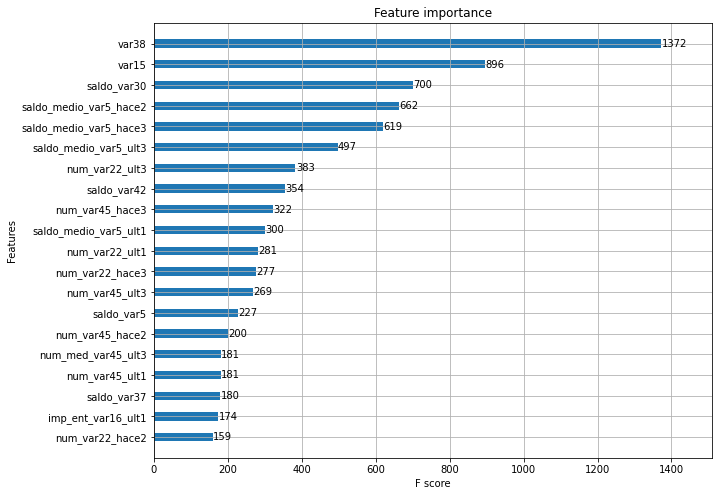

In [17]:
# 피처 중요도
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)

## 4. 모델링 (LightGBM)

In [20]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

확실히 XGBoost보다 수행 속도가 빠름

하이퍼 파라미터 튜닝 → num_leaves, max_depth, min_child_samples, subsample

In [22]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {
    'num_leaves':[32, 64],
    'max_depth':[128, 160],
    'min_child_samples':[60, 100],
    'subsample':[0.8, 1]
}

# cv = 3
gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터: ', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	v

In [24]:
# 해당 하이퍼 파라미터 적용 및 재학습
lgbm_clf = LGBMClassifier(n_estimaotrs = 1000, num_leaves = 32, subsample = 0.8, min_child_samples = 100, max_depth = 128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss